## Question answering with LDA
In this notebook, we attempt to use the trained [LDA topics model](./LDA.ipynb) to find information for the tasks. More specifically, for each task:

1) We define a set of keywords which define the task and treat the task a document consisting of these words.

2) Calculate the topic distribution of the "document" of the task.

3) Find the k abstracts with the most similar topic distributions to the task topic distribution.

In [1]:
import os
import json
from time import time
from collections import Counter

%matplotlib inline

import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon

### Load LDA model and papers data

In [2]:
print("Loading LDA model...")
lda_dir = os.path.join('data', 'lda_10_topics')
with open(os.path.join(lda_dir, 'model.pkl'), 'rb') as f:
    lda = pickle.load(f)
with open(os.path.join(lda_dir, 'vectorizer.pkl'), 'rb') as f:
    vectorizer = pickle.load(f)
with open(os.path.join(lda_dir, 'count_data.pkl'), 'rb') as f:
    count_data = pickle.load(f)

print("Loading all paper data...")
with open('data/all_text.json', 'r') as f:
    json_data = json.load(f)
    
paper_ids = list(json_data.keys())
index_to_paperid_map = {ind: paper_ids[ind] for ind in range(len(paper_ids))}

paper_topic_dist = lda.transform(count_data) # topic distribution of each paper

assert(len(paper_ids) == paper_topic_dist.shape[0])
paper_topic_dist.shape

Loading LDA model...
Loading all paper data...


(33375, 10)

In [3]:
def top_k_similar(paper_topic_dist: np.ndarray, query_topic_dist: np.ndarray, 
                  metric='euclidean', k=10, return_distances=False) -> list:
    """
        Input:
            paper_topic_dist - the LDA topic distribution of each paper
            query_topic_dist - the LDA topic distribution of the query
        Returns:
            Indicies of the papers closest in topic distribution to the query
    """
    assert(paper_topic_dist.ndim == 2)
    assert(paper_topic_dist.shape[1] == query_topic_dist.size)
    
    distances = pairwise_distances(paper_topic_dist, query_topic_dist.reshape(1, -1))
    distances = distances.flatten()
    
    assert(distances.shape[0] == paper_topic_dist.shape[0])
    
    indexed_distances = [(i, distances[i]) for i in range(distances.shape[0])]
    sorted_indexed_distances = sorted(indexed_distances, key=lambda p: p[1])
    ind, d = zip(*sorted_indexed_distances[:k])
    
    if return_distances:
        return ind, d
    else:
        return ind

### Task 1
#### What is known about transmission, incubation, and environmental stability? What do we know about natural history, transmission, and diagnostics for the virus? What have we learned about infection prevention and control?
* Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.
* Prevalence of asymptomatic shedding and transmission (e.g., particularly children)
* Seasonality of transmission
* Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).
* Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).
* Disease models, including animal models for infection, disease and transmission
* Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings

In [4]:
task1_questions = [
    "Range of incubation periods for the disease in humans and how this varies across age and health status and how long individuals are contagious, even after recovery.",
    "Prevalence of asymptomatic shedding and transmission particularly children", 
    "Seasonality season of transmission",
    "Physical science of the coronavirus charge distribution, adhesion to hydrophilic phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding",
    "Persistence and stability on a multitude of substrates and sources nasal discharge sputum  urine  fecal matter  blood",
    "Disease models including animal models for infection disease and transmission",
    "Effectiveness of movement control strategies to prevent secondary transmission in health care healthcare and community settings"]

task1_document = '. '.join(task1_questions)
task1_counts = vectorizer.transform([task1_document])[0]
task1_topic_dist = lda.transform(task1_counts.reshape(1, -1))[0]

assert(task1_topic_dist.sum() == 1)
task1_topic_dist

array([0.14472785, 0.04632768, 0.21557333, 0.0307841 , 0.01620475,
       0.00092609, 0.0347647 , 0.0557862 , 0.40437845, 0.05052684])

In [5]:
def display_closest_papers(indices: list, distances: list):
    for ind, d in zip(indices, distances):
        print("------------------------------------------------")
        print(d)
        paper_id = index_to_paperid_map[ind]
        abstract = json_data[paper_id]['abstract']
        title = json_data[paper_id]['title']
        print("Title: ", title)
        print("Abstract: ", abstract)

In [6]:
indices, distances = top_k_similar(paper_topic_dist, task1_topic_dist, 
                                   return_distances=True, k=5, metric=jensenshannon)
display_closest_papers(indices, distances)

------------------------------------------------
0.06884586410941963
Title:  Minimising prescribing errors in the ICU DJ Melia, S Saha Queen' s Hospital, Romford, UK Critical Care
Abstract:  We aimed to audit the prescribing practice on a busy 14-bedd general ICU, and develop standardised practices and tools to improve safety. Prescribing errors occur as commonly as in 10% of UK hospital admissions, costing 8.5 extra bed days per admission, and costing the National Health Service an estimated £1 billion per annum [1]. The majority of these mistakes are avoidable [2]. Methods We audited the daily infusion charts of all patients in three separate spot checks, over 1 week. We assessed all aspects of prescriptions that make them legal and valid, in accordance with national guidance [3]. New procedures were introduced, which included a standardised prescription sticker, with common, preprinted, infusion prescriptions on (noradrenaline, propofol, and so forth), and education on using the new

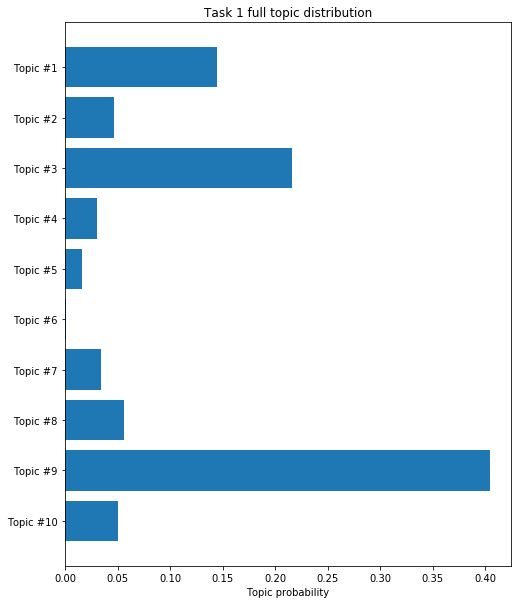

In [23]:
def plot_topic_dist(topic_dist: np.ndarray, title='Topic distribution'):
    n_topics = topic_dist.shape[0]
    
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(8)
    ax.barh(np.arange(n_topics), topic_dist, align='center')
    ax.set_yticks(np.arange(n_topics))
    ax.set_yticklabels(["Topic #{}".format(i + 1) for i in range(n_topics)])
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.set_xlabel('Topic probability')
    ax.set_title(title)
    plt.show()

plot_topic_dist(task1_topic_dist, title='Task 1 full topic distribution')

### Task 1: Prevalence of asymptomatic shedding and transmission particularly children.

In [11]:
question = "Prevalence of asymptomatic shedding and transmission particularly children."
question_counts = vectorizer.transform([question])[0]
question_topic_dist = lda.transform(question_counts.reshape(1, -1))[0]
question_topic_dist

array([0.0111145 , 0.71456275, 0.01111416, 0.01111266, 0.01111225,
       0.01111195, 0.01111239, 0.01111523, 0.196532  , 0.01111212])

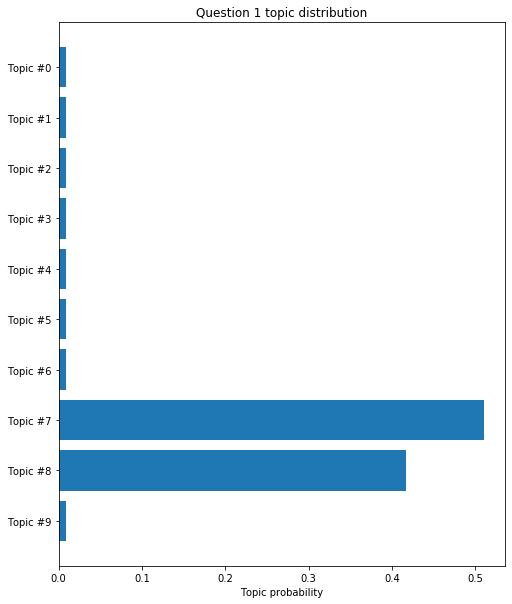

In [22]:
plot_topic_dist(question_topic_dist, title='Question 1 topic distribution')

In [12]:
indices, distances = top_k_similar(paper_topic_dist, question_topic_dist, 
                                   return_distances=True, k=5, metric=jensenshannon)
display_closest_papers(indices, distances)

------------------------------------------------
0.056111108224192394
Title:  Environmental investigation of respiratory pathogens during the Hajj 2016 and 2018
Abstract:  Background: Respiratory tract infections are common in the context of the Hajj pilgrimage and respiratory pathogens can be transmitted via contact with contaminated surfaces. We sampled surfaces during the Hajj to detect the presence of respiratory bacteria and viruses. Methods: Frequently touched surfaces at Mecca, Mina, Arafat and Medina were sampled. The common respiratory pathogens were tested by qPCR. Results: 70/142 (49.3%) environmental samples collected were positive for at least one respiratory pathogen. Among the positive samples, Klebsiella pneumoniae was the bacterium most frequently tested positive (57.1%), followed by Streptococcus pneumoniae (12.9%), Staphylococcus aureus (10.0%) and Haemophilus influenzae (7.1%). 32.9% positive samples tested positive for rhinovirus and 1.4% for coronavirus. Surfaces 

### Task 1: Disease models including animal models for infection disease and transmission

In [19]:
question = "Disease models including animal models for infection disease and transmission."
question_counts = vectorizer.transform([question])[0]
question_topic_dist = lda.transform(question_counts.reshape(1, -1))[0]
question_topic_dist

array([0.00909392, 0.00909167, 0.00909434, 0.00909145, 0.009093  ,
       0.00909176, 0.00909166, 0.51034465, 0.41691448, 0.00909305])

In [20]:
indices, distances = top_k_similar(paper_topic_dist, question_topic_dist, 
                                   return_distances=True, k=5, metric=jensenshannon)
display_closest_papers(indices, distances)

------------------------------------------------
0.043891657144334455
Title:  Public health concerns of highly pathogenic avian influenza H5N1 endemicity in Africa
Abstract:  Highly pathogenic avian influenza virus (HPAIV) H5N1 was first officially reported in Africa in 2006; thereafter this virus has spread rapidly from Nigeria to 11 other African countries. This study was aimed at utilizing data from confirmed laboratory reports to carry out a qualitative evaluation of the factors responsible for HPAI H5N1 persistence in Africa and the public health implications; and to suggest appropriate control measures. Relevant publications were sought from data banks and repositories of FAO, OIE, WHO, and Google scholars. Substantiated data on HPAI H5N1 outbreaks in poultry in Africa and in humans across the world were mined. HPAI H5N1 affects poultry and human populations, with Egypt having highest human cases (346) globally. Nigeria had a reinfection from 2014 to 2015, with outbreaks in Côte 